In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reel
using Vec
using Distributions
using AdaptiveStressTesting
using Records
using Interact

In [2]:
type SimParams
    endtime::Int64
    logging::Bool
end

type CarSim
    p::SimParams
    scene::Scene             # The scene contains info about cars
    roadway::CrosswalkEnv         # roadway, layout of the road
    models::Dict{Int, DriverModel}     # driver models for each car
    actions::Array{Any,1}     # actions for each car, MCTS controls actions[1]
    initial::Scene
    states::Vector{Scene}        # Array that holds all states
    t::Int64                # To keep track of number of calls
end

### Modifying the render function to show the crosswalk

In [3]:
function AutoViz.render!(rendermodel::RenderModel, env::CrosswalkEnv)
    render!(rendermodel, env.roadway)

    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array(Float64, 2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, Cairo.CAIRO_LINE_CAP_BUTT))
    return rendermodel
end

### Simulation function and adaptive stress testing interface functions

In [4]:
function CarSim(params::SimParams, models::Dict{Int, DriverModel})

    roadway = gen_straight_roadway(2,100.0,origin = VecSE2(-50.0,0.0,0.0))

    cam = FitToContentCamera(0.0)
    crosswalk = Lane(LaneTag(2,1), gen_straight_curve(VecE2(0.0, -DEFAULT_LANE_WIDTH), VecE2(0.0, 2*DEFAULT_LANE_WIDTH), 2), width=2.0)
    cw_segment = RoadSegment(2, [crosswalk])
    push!(roadway.segments, cw_segment)
    sensor = SimpleSensor(0.1,0.1,0.0)
    env = CrosswalkEnv(roadway, crosswalk, sensor,Array{Any,1}(),Array{Any,1}())
    cw_roadway = Roadway([RoadSegment(2, [env.crosswalk])]);
    PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)
    scene = Scene()

    cars = [Vehicle(VehicleState(VecSE2(-35.0,0,0), roadway.segments[1].lanes[1],roadway, 11.17),
             VehicleDef(), 1), Vehicle(VehicleState(VecSE2(0.0,-2.0,π/2), env.crosswalk, cw_roadway, 1.4),
             PEDESTRIAN_DEF, 2)]

    car1 = cars[1]
    car2 = cars[2]
    push!(scene, car1)
    push!(scene, car2)
    initial = deepcopy(scene)
    env.observed = [car2]
    actions = get_actions!(Array(Any, length(scene)), scene, roadway, models)
    CarSim(params, scene, env, models, actions, initial, Vector{Scene}(), 0)
end

function initialize(sim::CarSim)
    sim.t = 0
    sim.scene = deepcopy(sim.initial)
    sim.roadway.observed = [sim.scene[2]]
    empty!(sim.roadway.noise)
    empty!(sim.states)
    if sim.p.logging
        push!(sim.states, deepcopy(sim.scene))
    end
end

function update(sim::CarSim)
    sim.t += 1
    get_actions!(sim.actions, sim.scene, sim.roadway, sim.models)
    tick!(sim.scene, sim.roadway.roadway, sim.actions, 0.1)
    prob = 0
    for i in 2:sim.scene.n
        prob = prob + sqmahal(sim.models[i], sim.actions[i])
    end
    prob = prob + sim.roadway.sensormodel.likelihood
    locs = [car.state.posG for car in sim.scene]
    dists = [dist(convert(VecE2, locs[1]), convert(VecE2, locs[i])) for i in 2:sim.scene.n]
    if sim.p.logging
        push!(sim.states, deepcopy(sim.scene))
    end
    return (prob, isevent(sim), minimum(dists))
end

function isevent(sim::CarSim)
    event = false
    E = [is_colliding(sim.scene[1], sim.scene[i])&&(sim.scene[1].state.v > 0.01) for i in 2:sim.scene.n]
    if any(x -> x > 0, E)
        event = true
    end
    return event
end

function isterminal(sim::CarSim)

    isevent(sim) || sim.t >= sim.p.endtime
end

function reward_fun(prob::Float64, event::Bool, terminal::Bool, dist::Float64,
                            ast::AdaptiveStressTest,sim::CarSim) #ast and sim not used in default
    r = - log(1 + sqrt(prob))
    if event
        r += 0.0
    elseif terminal #incur distance cost only if !event && terminal
        r += -10000 - 1000*dist
    end
    r
end


reward_fun (generic function with 1 method)

In [5]:
function run_sim(maxtime::Int64,s::Array{Float64,1},d::Int64,n::Int64,seed::Int64)
    const MAXTIME = maxtime #sim endtime
    const RNG_LENGTH = 2
    timestep = 0.1
    models = Dict{Int, DriverModel}()
    models[1] = Tim2DDriver(timestep, mlon = IntelligentDriverModel(), mlat = ProportionalLaneTracker())
    models[2] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0), s)

    sim_params = SimParams(MAXTIME, true)

    sim = CarSim(sim_params, models)

    ast_params = ASTParams(MAXTIME, RNG_LENGTH, seed, 0)
    ast = AdaptiveStressTest(ast_params, sim, initialize, update, isterminal, reward_fun)


    mcts_params = DPWParams()
    mcts_params.d = d
    mcts_params.ec = 100
    mcts_params.n = n
    mcts_params.k = 0.5
    mcts_params.alpha = 0.85
    mcts_params.kp = 1.0
    mcts_params.alphap = 0.0
    mcts_params.clear_nodes = true
    mcts_params.maxtime_s = realmax(Float64)
    mcts_params.top_k = 1
    mcts_params.rng_seed = UInt64(0)
    result = stress_test(ast, mcts_params)
    return sim, result.rewards, result.action_seqs, result.r_history

end

run_sim (generic function with 1 method)

In [9]:
sim, reward, action_seq, r_history = run_sim(100,[.01,.1],100,2000,30);

Step: 1 of 100
Size of sdict: 2000
Step: 2 of 100
Size of sdict: 3552
Step: 3 of 100
Size of sdict: 4397
Step: 4 of 100
Size of sdict: 5360
Step: 5 of 100
Size of sdict: 6438
Step: 6 of 100
Size of sdict: 7378
Step: 7 of 100
Size of sdict: 8133
Step: 8 of 100
Size of sdict: 8109
Step: 9 of 100
Size of sdict: 2009
Step: 10 of 100
Size of sdict: 2624
Step: 11 of 100
Size of sdict: 2931
Step: 12 of 100
Size of sdict: 3191
Step: 13 of 100
Size of sdict: 2717
Step: 14 of 100
Size of sdict: 3716
Step: 15 of 100
Size of sdict: 4094
Step: 16 of 100
Size of sdict: 2016
Step: 17 of 100
Size of sdict: 2700
Step: 18 of 100
Size of sdict: 3326
Step: 19 of 100
Size of sdict: 2032
Step: 20 of 100
Size of sdict: 2043
Step: 21 of 100
Size of sdict: 2143
Step: 22 of 100
Size of sdict: 2129
Step: 23 of 100
Size of sdict: 2063
Step: 24 of 100
Size of sdict: 2094
Step: 25 of 100
Size of sdict: 2039
Step: 26 of 100
Size of sdict: 2030
Step: 27 of 100
Size of sdict: 2047
Step: 28 of 100
Size of sdict: 2118
S

### Use the slider to see the failure scenario step by step
using Interact

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 47 Any , "idx", 47, "47", 47, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(68, "68"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(89, "89"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(85, "85"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42")…)), Any[], Any[], true, "horizontal")

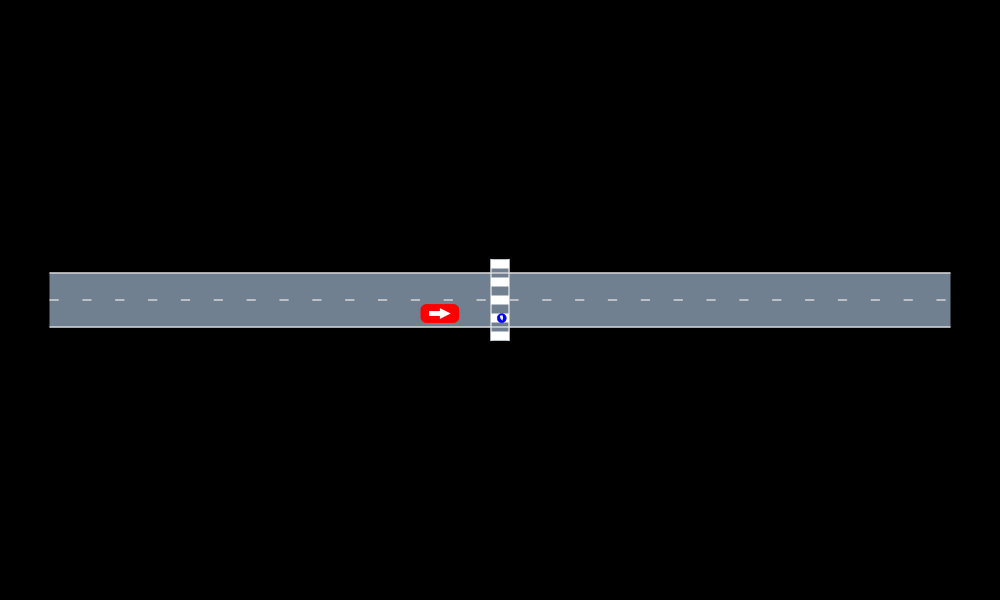

In [10]:
carcolors = Dict{Int,Colorant}()
carcolors[1] = colorant"red"
carcolors[2] = colorant"blue"
@manipulate for idx = 1:length(sim.states)
    render(sim.states[idx], sim.roadway, cam=FitToContentCamera(), car_colors=carcolors)
end

### Save as a gif
using Reel

In [11]:
frames = Frames(MIME("image/png"), fps=10)
for frame in 1 : length(sim.states)
    s = render(sim.states[frame], sim.roadway, cam=FitToContentCamera(), car_colors=carcolors)
    push!(frames, s)
end
println("creating gif...")
write("collision.gif", frames)

creating gif...


"collision.gif"